### Portfolio Optimization

In [282]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns

import ffn

from math import sqrt
from scipy import stats

import cvxpy
from tqdm import tqdm, trange

mpl.style.use('seaborn')
%matplotlib inline

In [255]:
import pyfolio as pf

In [256]:
rets = pd.read_csv('altcoin_pairs_btc_8hr_rets.csv')
rets.index = rets['timestamp']
rets.index = pd.to_datetime(rets.index)
rets = rets.drop('timestamp', axis=1)
rets = rets.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
rets = rets.pct_change()
rets.tail(2)

,ETHUSDT WTCUSDT,ETHUSDT OAXUSDT,ETHUSDT CDTUSDT,ETHUSDT XZCUSDT,ETHUSDT FUELUSDT,ETHUSDT ADXUSDT,LTCUSDT OAXUSDT,LTCUSDT BTGUSDT,LTCUSDT EVXUSDT,NEOUSDT OAXUSDT,...,ARKUSDT XZCUSDT,RDNUSDT FUELUSDT,RDNUSDT ADXUSDT,XMRUSDT CDTUSDT,XMRUSDT XZCUSDT,XMRUSDT FUELUSDT,XMRUSDT ADXUSDT,XZCUSDT TNTUSDT,XZCUSDT FUELUSDT,XZCUSDT BCDUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-10-09 00:00:00,-0.000376,0.0,-0.001606,0.001781,0.0,0.0,0.0,-0.000216,0.0,0.009422,...,-0.001556,0.020039,0.0,-0.001464,0.0000,0.0,0.0,0.0,-0.003965,-0.008292
2019-10-09 08:00:00,-0.000117,0.0,0.000261,0.000000,0.0,0.0,0.0,0.002704,0.0,0.000000,...,-0.000367,-0.006124,0.0,0.000952,0.0024,0.0,0.0,0.0,-0.001110,-0.001868


In [257]:
daily_rets = rets.resample('D').last()
daily_rets = daily_rets.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
daily_rets.tail(2)

,ETHUSDT WTCUSDT,ETHUSDT OAXUSDT,ETHUSDT CDTUSDT,ETHUSDT XZCUSDT,ETHUSDT FUELUSDT,ETHUSDT ADXUSDT,LTCUSDT OAXUSDT,LTCUSDT BTGUSDT,LTCUSDT EVXUSDT,NEOUSDT OAXUSDT,...,ARKUSDT XZCUSDT,RDNUSDT FUELUSDT,RDNUSDT ADXUSDT,XMRUSDT CDTUSDT,XMRUSDT XZCUSDT,XMRUSDT FUELUSDT,XMRUSDT ADXUSDT,XZCUSDT TNTUSDT,XZCUSDT FUELUSDT,XZCUSDT BCDUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-10-08,0.000000,0.0,0.005376,-0.000326,0.004317,0.0,0.0,0.000419,0.0,0.0,...,-0.001347,0.078095,0.0,0.000000,0.0000,0.0,0.0,0.0,0.00000,0.003949
2019-10-09,-0.000117,0.0,0.000261,0.000000,0.000000,0.0,0.0,0.002704,0.0,0.0,...,-0.000367,-0.006124,0.0,0.000952,0.0024,0.0,0.0,0.0,-0.00111,-0.001868


In [258]:
subsample_rate = 30
n_secs = len(daily_rets.columns)

In [259]:
trad_roll_corr = daily_rets.rolling(subsample_rate, axis=0).corr(pairwise=True)[subsample_rate*len(daily_rets.columns):]
trad_roll_cov = daily_rets.rolling(subsample_rate, axis=0).cov(pairwise=True)[subsample_rate*len(daily_rets.columns):]

roll_cov_vals = trad_roll_cov.values.reshape((len(trad_roll_cov) // n_secs, n_secs, n_secs))
roll_corr_vals = trad_roll_corr.values.reshape((len(trad_roll_corr) // n_secs, n_secs, n_secs))

tri = np.tril_indices(n_secs, k=-1)

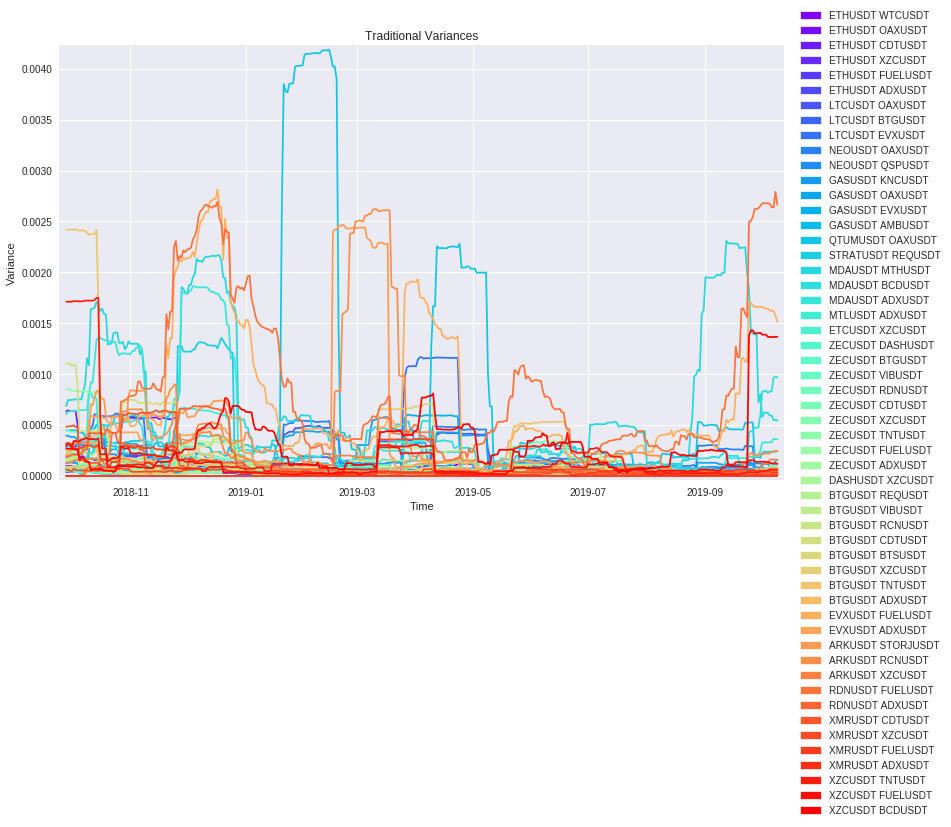

In [260]:
plt.figure(figsize=(13, 8))

colors = cm.rainbow(np.linspace(0, 1, n_secs))

handles = []

#roll_cov_vals = trad_roll_cov.values.reshape((len(trad_roll_cov) // n_secs, n_secs, n_secs))

for n, c in zip(range(n_secs), colors):
    plt.plot(
        trad_roll_cov.index.levels[0][subsample_rate:],
        roll_cov_vals[:, n, n],
        alpha = 1.0,
        color=c
    )
    handles.append(
        mpatches.Patch(
            color=c,
            label=rets.columns[n]
        )
    )
plt.margins(0.01)    
plt.title('Traditional Variances')
plt.legend(handles=handles,bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.xlabel('Time')
plt.ylabel('Variance');

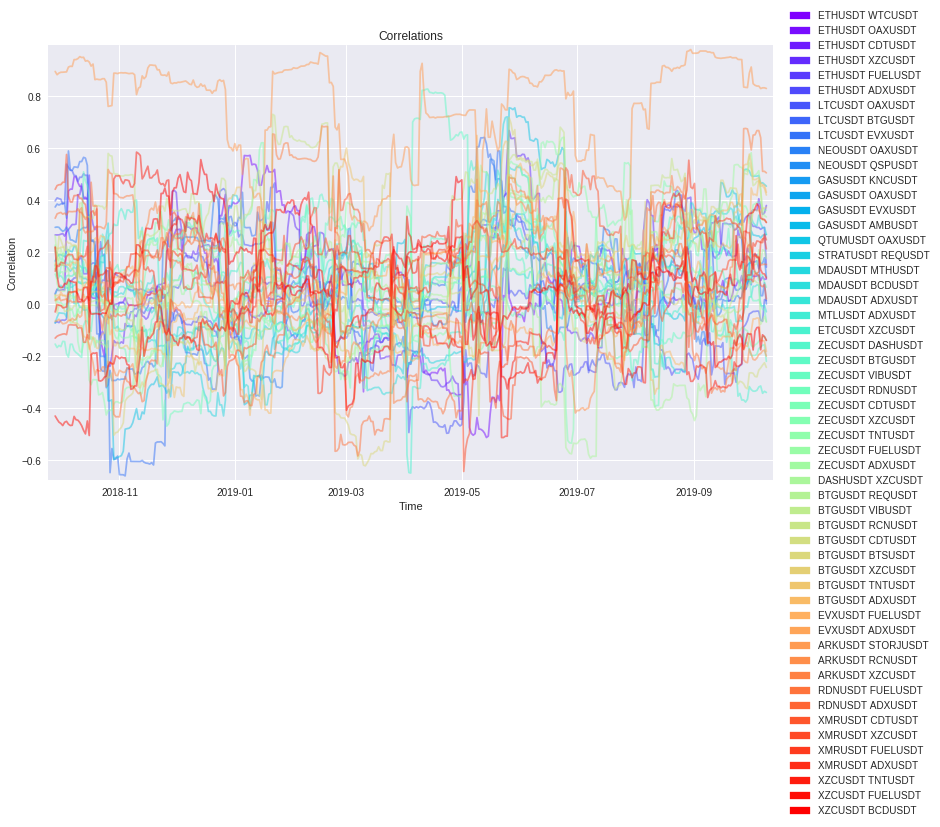

In [261]:
plt.figure(figsize=(13, 8))

colors = cm.rainbow(np.linspace(0, 1, n_secs))

handles = []

for n, c in zip(range(len(tri[0])), colors):
    plt.plot(
        trad_roll_corr.index.levels[0][subsample_rate:],
        roll_corr_vals[:,tri[0][n], tri[1][n]],
        alpha = 0.5,
        color=c
    )
    handles.append(
        mpatches.Patch(
            color=c,
            label=rets.columns[n]
        )
    )
plt.margins(0.01)        
plt.title('Correlations')
plt.legend(handles=handles,bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.xlabel('Time')
plt.ylabel('Correlation');

In [264]:
i = 15

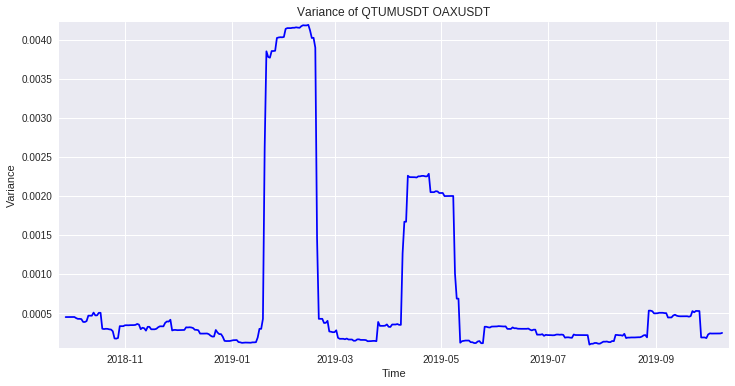

In [265]:
plt.figure(figsize=(12, 6))
plt.plot(
    trad_roll_cov.index.levels[0][subsample_rate:],
    roll_cov_vals[:, i, i],
    alpha = 1.0,
    color='blue'
)
plt.margins(0.01)    
plt.title('Variance of {0}'.format(rets.columns[i]))
plt.xlabel('Time')
plt.ylabel('Variance');

In [57]:
# Mean-Variance Optimization
def get_markowitz_weights(mu, Sigma, max_position=0.50, max_leverage=1.0, short=True):
    """ Obtain the Markowitz optimization weights for a given set of mean returns
    and covariance matrix.
    
    Parameters
    ----------
    mu : ndarray
        input array of returns
    Sigma : ndarray
        covariance matrix
    max_position : float, optional
        the maximum weight allowed for a position in any individual security
    max_leverage : float, >0, optional
        the maximum leverage allowed in the portfolio
    short : bool, optional
        allow negative positions
        
    Returns
    -------
    w : ndarray
        optimal weights for set of inputs"""
    w = cvxpy.Variable(len(Sigma))
    L = cvxpy.Parameter()
    L.value = max_leverage
    try:
        ret = mu.T*w
    except ValueError:
        ret = mu*w
    
    risk = cvxpy.quad_form(w, Sigma)
    
    objective = cvxpy.Maximize(ret - risk)
    constraints = [
        cvxpy.abs(w) <= max_position,
        cvxpy.norm(w, 1) <= L, # Make it so we don't have to invest everything
    ]
    
    if not short:
        constraints.append(w >= 0) # Force all positive weights
    
    prob = cvxpy.Problem(
        objective,
        constraints
    )
    
    result = prob.solve()
    
    return w.value

In [58]:
# use this to compute naive markowitz weights
matched_trad_roll_cov = roll_cov_vals[:(len(daily_rets)//subsample_rate*subsample_rate):subsample_rate]

In [59]:
max_position = 1.0
max_leverage = 1.0

In [61]:
trad_naive_min_var_weights = np.zeros((len(matched_trad_roll_cov), n_secs))

for t in trange(0, len(matched_trad_roll_cov)):
    trad_naive_min_var_weights[t, :] = get_markowitz_weights(
        np.ones(n_secs),
        matched_trad_roll_cov[t],
        max_position=max_position,
        max_leverage=max_leverage
    ).T

100%|██████████| 13/13 [00:00<00:00, 38.62it/s]


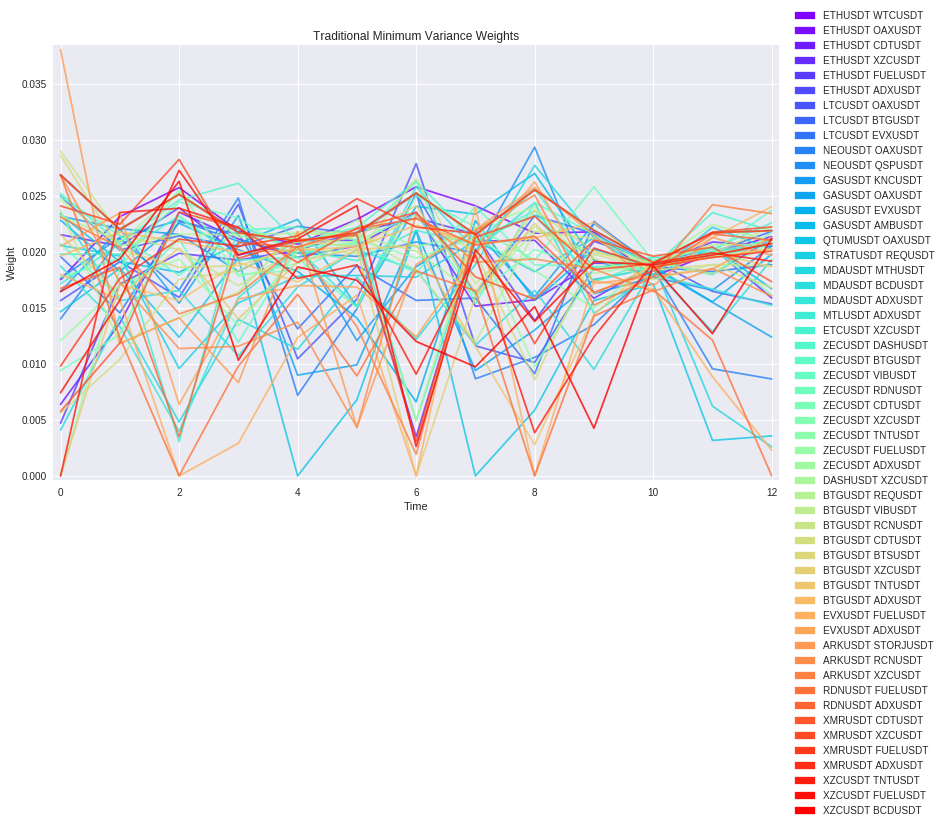

In [62]:
plt.figure(figsize=(13, 8))

colors = cm.rainbow(np.linspace(0, 1, n_secs))
handles = []
for n, c in zip(range(n_secs), colors):
    plt.plot(trad_naive_min_var_weights[:, n].T, alpha = 0.80, color=c)
    handles.append(
        mpatches.Patch(
            color=c,
            label=rets.columns[n]
        )
    )
plt.margins(0.01)    
plt.title('Traditional Minimum Variance Weights');
plt.legend(handles=handles,bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.xlabel('Time')
plt.ylabel('Weight');

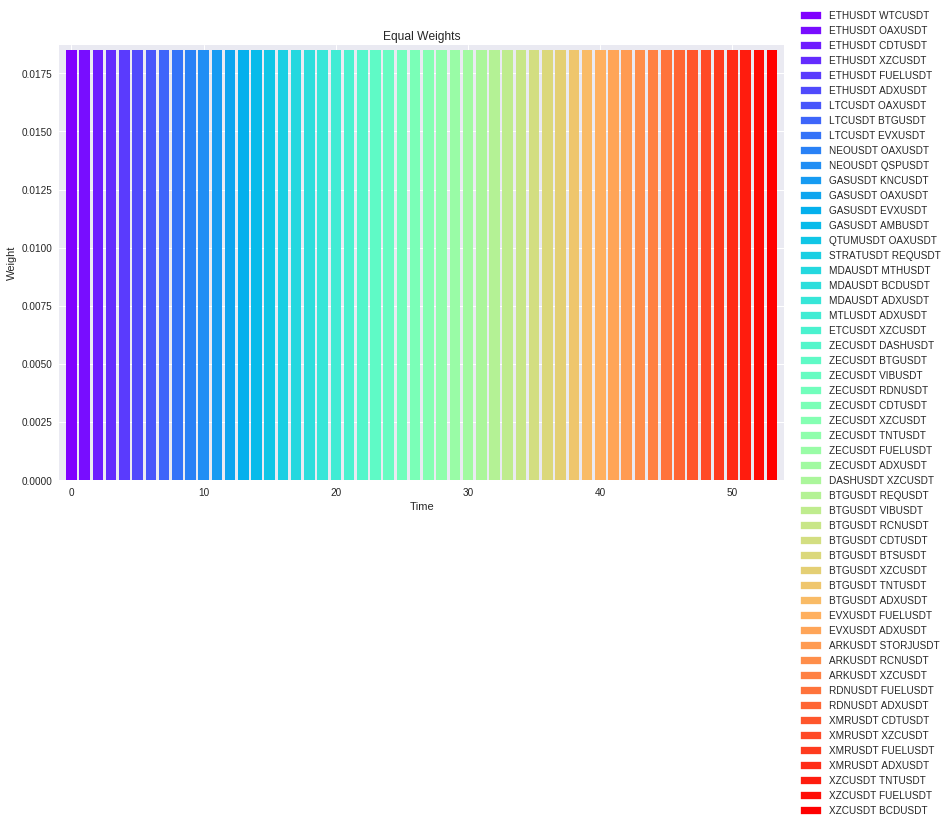

In [63]:
# Equal Weights 
eweights_df = len(daily_rets.columns) * [float(1)/len(daily_rets.columns)]
weights = eweights_df

plt.figure(figsize=(13, 8))
zz = np.arange(n_secs),weights
colors = cm.rainbow(np.linspace(0, 1, n_secs))
handles = []

for n, c in zip(range(n_secs), colors):
    plt.bar(np.arange(n_secs),weights, color=colors);
    handles.append(
        mpatches.Patch(
            color=c,
            label=rets.columns[n]
        )
    )
plt.margins(0.01)    
plt.title('Equal Weights');
plt.legend(handles=handles,bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.xlabel('Time')
plt.ylabel('Weight');

In [64]:
trad_weights_df = pd.DataFrame(
    np.repeat(trad_naive_min_var_weights, subsample_rate, axis=0)[:daily_rets[subsample_rate:].shape[0]],
    index=daily_rets[subsample_rate:].index,
    columns=daily_rets.columns
)

In [65]:
trad_weight_portfolio = (rets*trad_weights_df).dropna().sum(axis=1)
trad_weight_portfolio.name = "Traditional Portfolio"

In [66]:
trad_weight_portfolio0 = pd.DataFrame(trad_weight_portfolio)
trad_weight_portfolio0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 377 entries, 2018-09-28 to 2019-10-09
Data columns (total 1 columns):
Traditional Portfolio    377 non-null float64
dtypes: float64(1)
memory usage: 5.9 KB


In [67]:
results_df = daily_rets.loc['2018-09-28 ':'2019-10-08']

results_df /= len(results_df.columns)

final_res = results_df.sum(axis=1)

In [68]:
BTC_Pair_Rets = trad_weight_portfolio
BTC_Pair_Rets = pd.DataFrame(BTC_Pair_Rets)
BTC_Pair_Rets = BTC_Pair_Rets.fillna(0)
BTC_Pair_Rets.columns = ['BTC_Pairs_Returns']

In [69]:
BTC_Pair_Rets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 377 entries, 2018-09-28 to 2019-10-09
Data columns (total 1 columns):
BTC_Pairs_Returns    377 non-null float64
dtypes: float64(1)
memory usage: 5.9 KB


In [70]:
Spectral_Res_returns = final_res

Spectral_Res_stats = pf.timeseries.perf_stats(Spectral_Res_returns)
Spectral_Res_stats = Spectral_Res_stats.rename(columns={'perf_stats':'Equal Weight'})

Kmeans_Res_returns = BTC_Pair_Rets.BTC_Pairs_Returns

Kmeans_Res_stats = pf.timeseries.perf_stats(Kmeans_Res_returns)
Kmeans_Res_stats = Kmeans_Res_stats.rename(columns={'perf_stats':'Minimum Variance'})

In [71]:
#show performance statistics
perf_stats = [Spectral_Res_stats,Kmeans_Res_stats]
perf_stats = pd.concat(perf_stats,axis=1)
perf_stats.columns = ['Equal Weight','Minimum Variance']

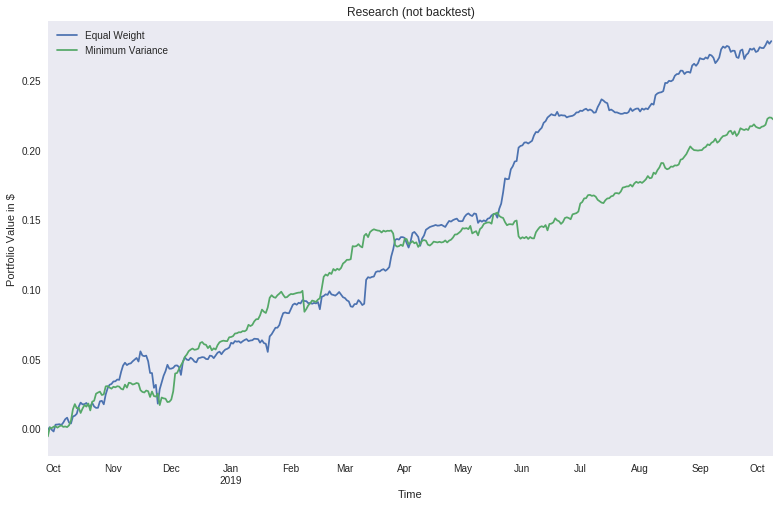

,Equal Weight,Minimum Variance
Annual return,0.203419,0.158778
Cumulative returns,0.318217,0.246656
Annual volatility,0.045566,0.039869
Sharpe ratio,4.087909,3.717262
Calmar ratio,5.493046,8.414550
Stability,0.978608,0.959780
Max drawdown,-0.037032,-0.018869
Omega ratio,2.213707,2.029693
Sortino ratio,7.485855,6.039666
Skew,0.494564,-0.395033


In [72]:
plt.figure(figsize=(13, 8))
Spectral_Res_returns.cumsum().plot(label="Equal Weight")
Kmeans_Res_returns.cumsum().plot(label="Minimum Variance")
plt.legend(loc='best')
plt.ylabel("Portfolio Value in $")
plt.xlabel("Time")
plt.grid(b=None, which=u'major', axis=u'both')
plt.title("Research (not backtest)");
plt.show()
perf_stats



	              Equal Weight 			                Minimum Variance


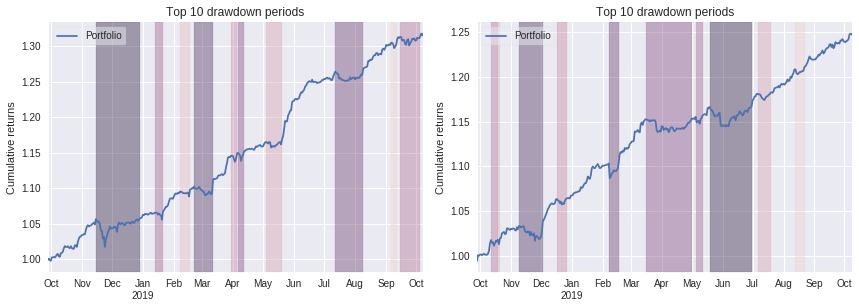

In [73]:
#################################################
#
#  Show Top 5 Drawdown Periods
#
#################################################
plt.figure(figsize=(18, 8))

ax1 = plt.subplot2grid((2,3), (0,0) )print('\n\n\t             Equal Weight')

ax2 = plt.subplot2grid((2,3), (0,1) )

print('\n\n\t              Equal Weight \t\t\t                Minimum Variance')

pf.plotting.plot_drawdown_periods(Spectral_Res_returns,ax=ax1)
pf.plotting.plot_drawdown_periods(Kmeans_Res_returns,ax=ax2)
plt.tight_layout()
plt.show();



	             Equal Weight 			               Minimum Variance


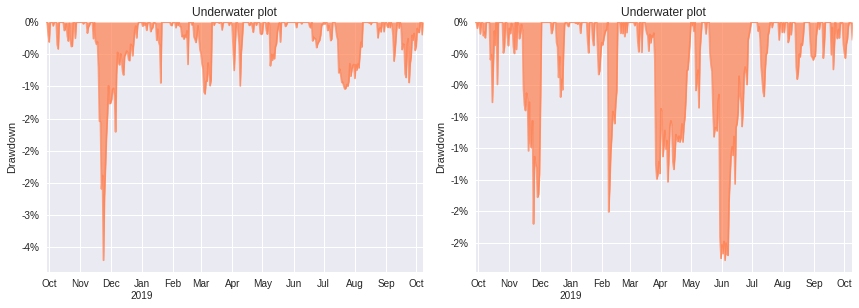

In [74]:
#################################################
#
#  Show Underwater Plot
#
#################################################
plt.figure(figsize=(18, 8))

ax1 = plt.subplot2grid((2,3), (0,0) )
ax2 = plt.subplot2grid((2,3), (0,1) )

print('\n\n\t             Equal Weight \t\t\t               Minimum Variance')

pf.plotting.plot_drawdown_underwater(Spectral_Res_returns,ax=ax1)
pf.plotting.plot_drawdown_underwater(Kmeans_Res_returns,ax=ax2)
plt.tight_layout()
plt.show();

In [75]:
print('\n\n\t             Equal Weight')
pf.timeseries.gen_drawdown_table(Spectral_Res_returns)



	             Equal Weight


,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.70321,2018-11-15,2018-11-24,2018-12-29,32
1,1.11618,2019-02-21,2019-03-05,2019-03-12,14
2,1.03939,2019-07-12,2019-07-22,2019-08-09,21
3,0.991247,2019-04-06,2019-04-09,2019-04-12,5
4,0.944788,2019-01-13,2019-01-20,2019-01-21,6
5,0.938391,2019-09-15,2019-09-24,2019-10-05,15
6,0.749668,2019-03-30,2019-04-03,2019-04-05,5
7,0.679803,2019-05-04,2019-05-09,2019-05-20,11
8,0.655464,2019-02-07,2019-02-16,2019-02-17,7
9,0.606031,2019-09-06,2019-09-09,2019-09-12,5


In [76]:
print('\n\n\t             Minimum Variance')

pf.timeseries.gen_drawdown_table(Kmeans_Res_returns)



	             Minimum Variance


,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.88695,2019-05-19,2019-06-04,2019-06-30,30
1,1.59903,2018-11-09,2018-11-25,2018-12-03,17
2,1.50393,2019-02-07,2019-02-08,2019-02-17,7
3,1.26554,2019-03-16,2019-04-08,2019-05-01,33
4,0.678722,2019-05-05,2019-05-09,2019-05-12,5
5,0.635305,2018-10-12,2018-10-15,2018-10-19,6
6,0.593396,2018-12-17,2018-12-22,2018-12-27,9
7,0.58865,2019-07-06,2019-07-13,2019-07-19,10
8,0.493728,2018-10-19,2018-10-20,2018-10-21,1
9,0.452129,2019-08-12,2019-08-15,2019-08-22,9




	             Equal Weight 			               Minimum Variance


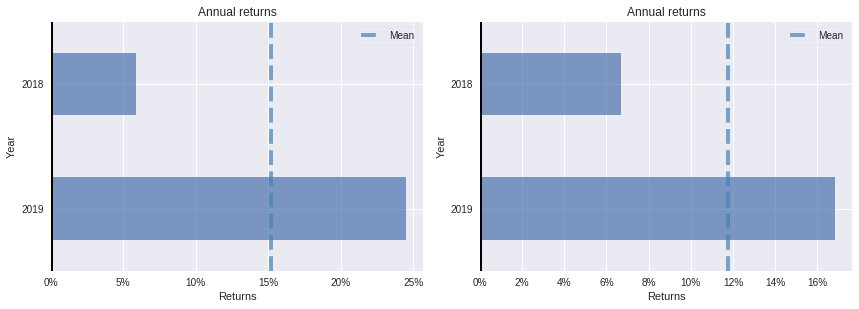

In [77]:
plt.figure(figsize=(18, 8))

ax1 = plt.subplot2grid((2,3), (0,0) )
ax2 = plt.subplot2grid((2,3), (0,1) )

print('\n\n\t             Equal Weight \t\t\t               Minimum Variance')

pf.plotting.plot_annual_returns(Spectral_Res_returns,ax=ax1)
pf.plotting.plot_annual_returns(Kmeans_Res_returns,ax=ax2)
plt.tight_layout()
plt.show();



	             Equal Weight 			               Minimum Variance


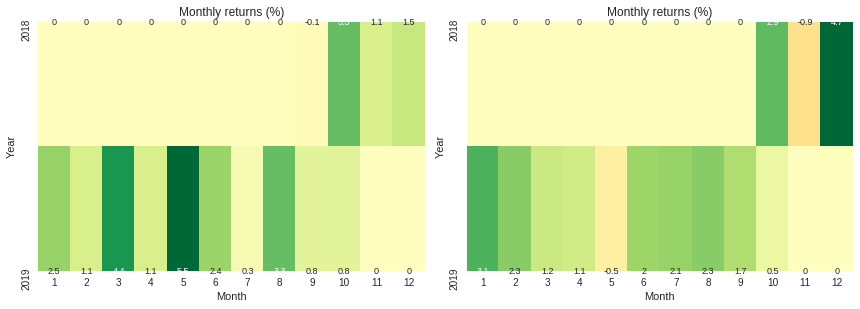

In [78]:
plt.figure(figsize=(18, 8))

ax1 = plt.subplot2grid((2,3), (0,0) )
ax2 = plt.subplot2grid((2,3), (0,1) )

print('\n\n\t             Equal Weight \t\t\t               Minimum Variance')

pf.plotting.plot_monthly_returns_heatmap(Spectral_Res_returns,ax=ax1)
pf.plotting.plot_monthly_returns_heatmap(Kmeans_Res_returns,ax=ax2)
plt.tight_layout()
plt.show();



	             Equal Weight 			               Minimum Variance


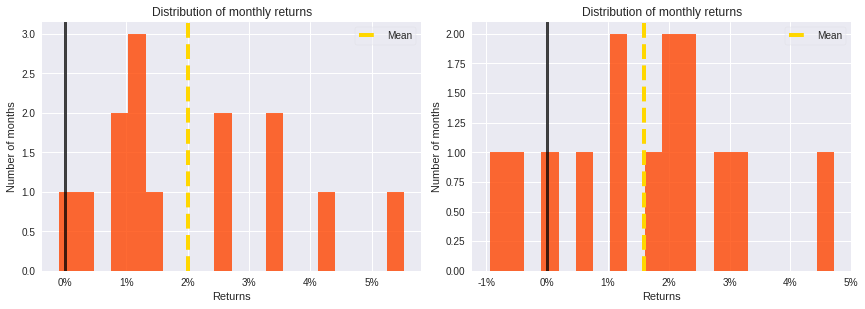

In [79]:
plt.figure(figsize=(18, 8))

ax1 = plt.subplot2grid((2,3), (0,0) )
ax2 = plt.subplot2grid((2,3), (0,1) )

print('\n\n\t             Equal Weight \t\t\t               Minimum Variance')

pf.plotting.plot_monthly_returns_dist(Spectral_Res_returns,ax=ax1)
pf.plotting.plot_monthly_returns_dist(Kmeans_Res_returns,ax=ax2)
plt.tight_layout()
plt.show();



	             Equal Weight 			               Minimum Variance


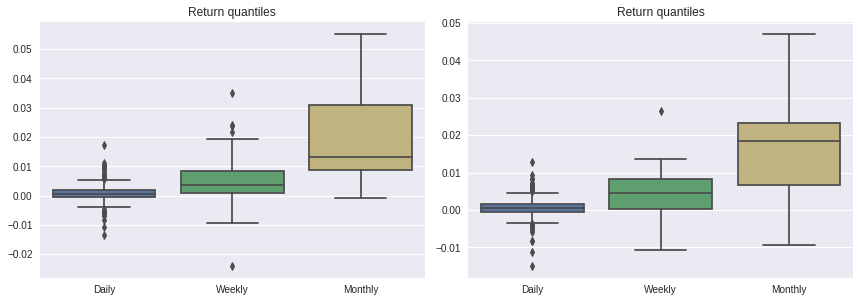

In [80]:
plt.figure(figsize=(18, 8))

ax1 = plt.subplot2grid((2,3), (0,0) )
ax2 = plt.subplot2grid((2,3), (0,1) )

print('\n\n\t             Equal Weight \t\t\t               Minimum Variance')

pf.plot_return_quantiles(Spectral_Res_returns,ax=ax1)
pf.plot_return_quantiles(Kmeans_Res_returns,ax=ax2)
plt.tight_layout()
plt.show();



	             Equal Weight 			               Minimum Variance


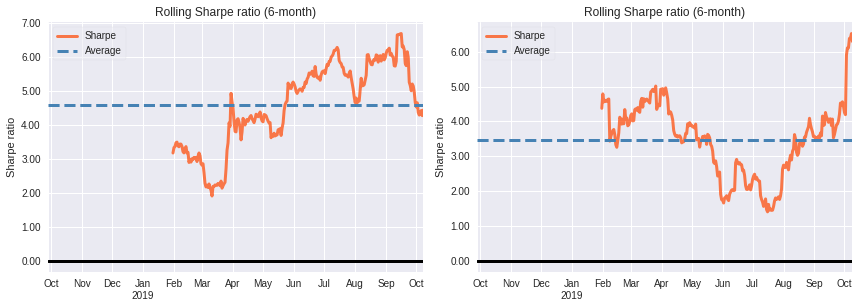

In [81]:
plt.figure(figsize=(18, 8))

ax1 = plt.subplot2grid((2,3), (0,0) )
ax2 = plt.subplot2grid((2,3), (0,1) )

print('\n\n\t             Equal Weight \t\t\t               Minimum Variance')

pf.plotting.plot_rolling_sharpe(Spectral_Res_returns,ax=ax1)
pf.plotting.plot_rolling_sharpe(Kmeans_Res_returns,ax=ax2)
plt.tight_layout()
plt.show();